<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/Again_Training_Exp05_Just_20Epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.MD
* Try Again, Fin...Fin...Fin...!!
* back to Original Kingma's VAE to Malimg
    * optimizer learning rate: 1e-3
    * optimizer params: sum
* Add 
    * plot train, test loss
        * save it every Epochs
    * plot latent vector per 10 Epoch
        * save it every 10 Epoch
    * save model's state dict per 10 Epoch
    * save latent vector per 10 Epoch

* ✅ Check Point
    * Just try it again...!
    * last exp result is not so good.
        * I think it is the limitation of linear combination...
    * Train again to get some results
    
* Final Trial
    * Train 200 Epoch
    * Keep Saving & Training
## Reference
* Reference repository: https://github.com/pytorch/examples/tree/master/vae

* Reference for Visualization: https://github.com/tayden/VAE-Latent-Space-Explorer/blob/master/scripts/VAE.ipynb


In [1]:
! nvidia-smi

Sat Jul  4 12:10:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# drive mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd drive/My\ Drive/InfoSec_Summer_part2
! pwd

/content/drive/My Drive/InfoSec_Summer_part2
/content/drive/My Drive/InfoSec_Summer_part2


## 01. Import Library

In [5]:
from PIL import Image
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
 
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
import seaborn as sns

# save single numpy array
# https://numpy.org/doc/stable/reference/generated/numpy.save.html#numpy.save
from tempfile import TemporaryFile
from sklearn.manifold import TSNE

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 02. Data Preprocessing
* Load dataset
* preprocess it
    * transforms
    * make custom dataset
    * train_test split: <code>torch.utils.data.random_split</code>
    * train_test_loader

### Work Flow
* transforms module 사용해서 image data compose 하기
    * size 조정, normalize, tensor 변환
* ImageFolder를 이용해 dataload
* dataset split: train dataset, test dataset
* DataLoader로 batch단위 dataset 불러오기

In [6]:
transforms = transforms.Compose([
                                transforms.Resize((224, 224)),                # Change size of Image to (224, 224)
                                transforms.Grayscale(num_output_channels=1),  # Makes it 1-dimension channel
                                transforms.ToTensor(),                        # Convert a PIL Image or numpy.ndarray to tensor.
                                                                              # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8
                                                                              # In the other cases, tensors are returned without scaling.
                                # transforms.Normalize(mean=[0.5], std=[0.5]),
                                
                                ])

# make custom dataset
trainset = torchvision.datasets.ImageFolder(root='../InformationSecurity_Summer/malimg',
                                            transform=transforms)  # make custom dataset

In [7]:
trainset

Dataset ImageFolder
    Number of datapoints: 9339
    Root location: ../InformationSecurity_Summer/malimg
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [8]:
# classes = trainset.classes
classes = trainset.classes
classes

['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

In [9]:
full_dataset = trainset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
print(train_size, test_size)

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

7471 1868


In [10]:
'''
for idx, (data, _) in enumerate(test_dataset):
    if idx == 5: 
        break
    else:
        print(data, _)
'''

'\nfor idx, (data, _) in enumerate(test_dataset):\n    if idx == 5: \n        break\n    else:\n        print(data, _)\n'

In [11]:
train_loader = DataLoader(train_dataset,
                         batch_size=16,
                         shuffle=True,
                         pin_memory=True) 
test_loader = DataLoader(test_dataset,
                        batch_size=16,
                        shuffle=True,
                        pin_memory=True)  # Instead, we recommend using automatic memory pinning (i.e., setting pin_memory=True)
                                          #  which enables fast data transfer to CUDA-enabled GPUs

# First, insert all test dataset
# test_loader_10: testloader for latent vector visualization
test_loader_10 = DataLoader(test_dataset,
                        batch_size=1868,
                        shuffle=True,
                        pin_memory=True)

In [12]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()

    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Convert (C, W, H) to (W, H, C)

    print(np_img.shape)  # np_img shape
    print((np.transpose(np_img, (1, 2, 0))).shape)  # transposed shape 

In [13]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([23, 15, 24, 14, 18,  2,  2, 22, 24,  2, 24, 21,  2,  3,  2,  3])


torch.Size([16, 1, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 1, 224, 224])
torch.Size([3, 454, 1810])
Wintrim.BX Lolyda.AT Yuner.A Lolyda.AA3 Rbot!gen Allaple.A Allaple.A VB.AT Yuner.A Allaple.A Yuner.A Swizzor.gen!I Allaple.A Allaple.L Allaple.A Allaple.L 


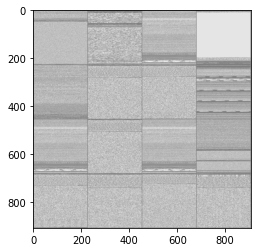

In [14]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(16)))

## 03. Define VAE Class
* Initialize
    * (224, 224) input 이미지를 통해 1차원 100개의 latent vector를 생성하는 Encoder네트워크 정의
    * 100개의 latent vector로부터 X_hat을 복원하는 Decoder Network 정의
* encode
* reparameterize
* decode
* forward

In [15]:
device = torch.device("cuda")  # device = torch.device("cuda")

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(224*224, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1000)
        self.fc4 = nn.Linear(1000, 224*224)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
# loss값이 안줄면 sigmoid함수를 제거하고 BCE with Logits Loss를 사용해볼까?
# https://nuguziii.github.io/dev/dev-002/

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 224*224))
        z = self.reparameterize(mu, logvar)  # z's shape => (batch_size, 100)
        return self.decode(z), mu, logvar, z

In [16]:
model = VAE().to(device)
print(model)

VAE(
  (fc1): Linear(in_features=50176, out_features=1000, bias=True)
  (fc21): Linear(in_features=1000, out_features=100, bias=True)
  (fc22): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=50176, bias=True)
)


In [17]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [18]:
get_n_params(model)  

100704376

*Note*<br>
1-milion params.... it is so huge...

In [19]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [20]:
# track and save train, test loss through Dictionary
# 
Epoch_Loss = {'train_epoch':[],
              'train_loss':[],
              'test_epoch':[],
              'test_loss':[]}

# Save & Loading Model for Inference
# Reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html

# PATH = '/Again_original_Exp01_200-Epoch.pth'

PATH = 'Epochs.pth'
# latent_vector = np.zeros((16, 100))
color_palette = np.zeros((1868))


In [21]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 224*224), reduction='sum')  # (input, target, ... reduction)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    # latent_vector = np.zeros(())
    # latent_label = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, z= model(data)
    
       
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
    Epoch_Loss['train_epoch'].append(epoch)
    Epoch_Loss['train_loss'].append(train_loss / len(train_loader.dataset))
   
def test(epoch):
    # 10 Epoch 단위로 작업
    # model.state_dict() 저장 및 latent_vector 저장
    # plot latent vector
    if epoch % 10 == 0:  # Epoch이 10의 배수일때
     # save model.state_dict() per 10 Epochs
        torch.save(model.state_dict(), ('./Exp05_results/model_save_' + str(epoch) + PATH))  # Epoch 단위 parameter 저장

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (data, _) in enumerate(test_loader):
                data = data.to(device)
                recon_batch, mu, logvar, z = model(data)
                # z vector는 torch type
                # latent_vector = z.detach().cpu().clone().numpy()
                test_loss += loss_function(recon_batch, data, mu, logvar).item()
                if i == 0:
                    n = min(data.size(0), 8)
                    comparison = torch.cat([data[:n],
                                        recon_batch.view(16, 1, 224, 224)[:n]])
                    save_image(comparison.cpu(),
                            './Exp05_results/recon_sampling/reconstruction_' + str(epoch) + '.png', nrow=n)
        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
        Epoch_Loss['test_epoch'].append(epoch)
        Epoch_Loss['test_loss'].append(test_loss)

        # save latent vector's every 10 Epoch's
        # load_whole test_data 
        for i, (data, _) in enumerate(test_loader_10):  # load_whole test_data
            data = data.to(device)
            recon_batch, mu, logvar, z = model(data)
        # save latent_vector per 10 Epochs
            latent_vector = z.detach().cpu().clone().numpy()  # change tensor type data to cpu().numpy()
                                                              # latent_vector_size: (num_of_data, 100)
            color_palette = _.detach().cpu().clone().numpy()
            with open(('./Exp05_results/'+str(epoch)+'Epoch_z_vector.npy'), 'wb') as f:
                np.save(f, latent_vector)  # but latent vector size is (16, 100).... just 16...
                                           # 10 Epoch 단위로 latent vector를 저장한다
                                           # 이 떄, latent vector의 size는 test_dataset의 크기가 되어야 한다
                                           # 결과값이 좋은 vector는 좋은 feature로 사용할 수 있다.
        # plot latent vector Every 10 Epochs
        # t-SNE for Dimensionality reduction
        Z_embedded = TSNE(n_components=2).fit_transform(latent_vector)
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # setup the plot

        x = Z_embedded[:, 0]
        y = Z_embedded[:, 1]
        label = color_palette
        # label[10:12] = 0  # make sure there are some 0 values to show up as grey
        print("=="*20, "params", "=="*20)
        print("Z_embedded.shape:", Z_embedded.shape)
        print("label.shape:", label.shape)
        # tsne_data = np.vstack((Z_embedded, label))
        tsne_data = np.c_[Z_embedded, label]
        tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
        sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
        plt.savefig('./Exp05_results/plot_latent_vector/' + str(epoch) + '_t_SNE.png', dpi=300)
        plt.show()

    elif epoch % 10 !=0:
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (data, _) in enumerate(test_loader):
                data = data.to(device)
                recon_batch, mu, logvar, z = model(data)
                # z vector는 torch type
                # latent_vector = z.detach().cpu().clone().numpy()
                test_loss += loss_function(recon_batch, data, mu, logvar).item()
                if i == 0:
                    n = min(data.size(0), 8)
                    comparison = torch.cat([data[:n],
                                        recon_batch.view(16, 1, 224, 224)[:n]])
                    save_image(comparison.cpu(),
                            './Exp05_results/recon_sampling/reconstruction_' + str(epoch) + '.png', nrow=n)
        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
        Epoch_Loss['test_epoch'].append(epoch)
        Epoch_Loss['test_loss'].append(test_loss)

*Notice*<br>
Train Again!<br>
Change BCE loss param_reduction to 'sum'

1
Train Epoch: 1 [0/7471 (0%)]	Loss: 35154.285156
Train Epoch: 1 [160/7471 (2%)]	Loss: 37511.867188
Train Epoch: 1 [320/7471 (4%)]	Loss: 36945.175781
Train Epoch: 1 [480/7471 (6%)]	Loss: 59083.949219
Train Epoch: 1 [640/7471 (9%)]	Loss: 38263.203125
Train Epoch: 1 [800/7471 (11%)]	Loss: 37079.707031
Train Epoch: 1 [960/7471 (13%)]	Loss: 36264.871094
Train Epoch: 1 [1120/7471 (15%)]	Loss: 36680.339844
Train Epoch: 1 [1280/7471 (17%)]	Loss: 35968.847656
Train Epoch: 1 [1440/7471 (19%)]	Loss: 39116.437500
Train Epoch: 1 [1600/7471 (21%)]	Loss: 37057.906250
Train Epoch: 1 [1760/7471 (24%)]	Loss: 36878.097656
Train Epoch: 1 [1920/7471 (26%)]	Loss: 35958.417969
Train Epoch: 1 [2080/7471 (28%)]	Loss: 35282.820312
Train Epoch: 1 [2240/7471 (30%)]	Loss: 35904.281250
Train Epoch: 1 [2400/7471 (32%)]	Loss: 38730.101562
Train Epoch: 1 [2560/7471 (34%)]	Loss: 41958.386719
Train Epoch: 1 [2720/7471 (36%)]	Loss: 37988.898438
Train Epoch: 1 [2880/7471 (39%)]	Loss: 37113.765625
Train Epoch: 1 [3040/747

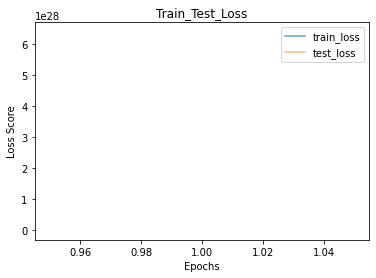

2
Train Epoch: 2 [0/7471 (0%)]	Loss: 5759892056965120.000000
Train Epoch: 2 [160/7471 (2%)]	Loss: 5890421771074317320192.000000
Train Epoch: 2 [320/7471 (4%)]	Loss: 3030404638441472.000000
Train Epoch: 2 [480/7471 (6%)]	Loss: 5923046409724942614528.000000
Train Epoch: 2 [640/7471 (9%)]	Loss: 5328874372071424.000000
Train Epoch: 2 [800/7471 (11%)]	Loss: 5413628035465216.000000
Train Epoch: 2 [960/7471 (13%)]	Loss: 7244102294831104.000000
Train Epoch: 2 [1120/7471 (15%)]	Loss: 2227900065513472.000000
Train Epoch: 2 [1280/7471 (17%)]	Loss: 3926023431258112.000000
Train Epoch: 2 [1440/7471 (19%)]	Loss: 4864570690633728.000000
Train Epoch: 2 [1600/7471 (21%)]	Loss: 4613016603590656.000000
Train Epoch: 2 [1760/7471 (24%)]	Loss: 3380737336147968.000000
Train Epoch: 2 [1920/7471 (26%)]	Loss: 11423328663429548343296.000000
Train Epoch: 2 [2080/7471 (28%)]	Loss: 3956538368589824.000000
Train Epoch: 2 [2240/7471 (30%)]	Loss: 4931555537453056.000000
Train Epoch: 2 [2400/7471 (32%)]	Loss: 465087190

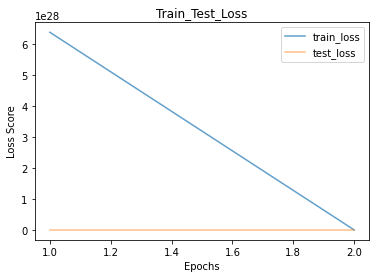

3
Train Epoch: 3 [0/7471 (0%)]	Loss: 48379.523438
Train Epoch: 3 [160/7471 (2%)]	Loss: 4966615355490304.000000
Train Epoch: 3 [320/7471 (4%)]	Loss: 5780216479744.000000
Train Epoch: 3 [480/7471 (6%)]	Loss: 3765458698240.000000
Train Epoch: 3 [640/7471 (9%)]	Loss: 643824484352.000000
Train Epoch: 3 [800/7471 (11%)]	Loss: 1761273343639552.000000
Train Epoch: 3 [960/7471 (13%)]	Loss: 1325220102144.000000
Train Epoch: 3 [1120/7471 (15%)]	Loss: 1973648359424.000000
Train Epoch: 3 [1280/7471 (17%)]	Loss: 2264828739584.000000
Train Epoch: 3 [1440/7471 (19%)]	Loss: 1306051084288.000000
Train Epoch: 3 [1600/7471 (21%)]	Loss: 824036116398080.000000
Train Epoch: 3 [1760/7471 (24%)]	Loss: 993033125888.000000
Train Epoch: 3 [1920/7471 (26%)]	Loss: 2609895440384.000000
Train Epoch: 3 [2080/7471 (28%)]	Loss: 1099122606080.000000
Train Epoch: 3 [2240/7471 (30%)]	Loss: 2101607006208.000000
Train Epoch: 3 [2400/7471 (32%)]	Loss: 1397589540864.000000
Train Epoch: 3 [2560/7471 (34%)]	Loss: 1668073390080.0

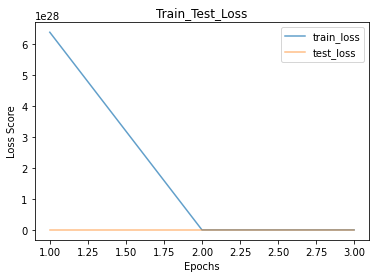

4
Train Epoch: 4 [0/7471 (0%)]	Loss: 2584842862592.000000
Train Epoch: 4 [160/7471 (2%)]	Loss: 1625098682368.000000
Train Epoch: 4 [320/7471 (4%)]	Loss: 1980140879872.000000
Train Epoch: 4 [480/7471 (6%)]	Loss: 1908639137792.000000
Train Epoch: 4 [640/7471 (9%)]	Loss: 2401926643712.000000
Train Epoch: 4 [800/7471 (11%)]	Loss: 1044195508224.000000
Train Epoch: 4 [960/7471 (13%)]	Loss: 487345744773120.000000
Train Epoch: 4 [1120/7471 (15%)]	Loss: 445480148402176.000000
Train Epoch: 4 [1280/7471 (17%)]	Loss: 980346077184.000000
Train Epoch: 4 [1440/7471 (19%)]	Loss: 1798755450880.000000
Train Epoch: 4 [1600/7471 (21%)]	Loss: 2034960826368.000000
Train Epoch: 4 [1760/7471 (24%)]	Loss: 649399369728.000000
Train Epoch: 4 [1920/7471 (26%)]	Loss: 929043973144576.000000
Train Epoch: 4 [2080/7471 (28%)]	Loss: 1004329304064.000000
Train Epoch: 4 [2240/7471 (30%)]	Loss: 707823140864.000000
Train Epoch: 4 [2400/7471 (32%)]	Loss: 764876028903424.000000
Train Epoch: 4 [2560/7471 (34%)]	Loss: 87269118

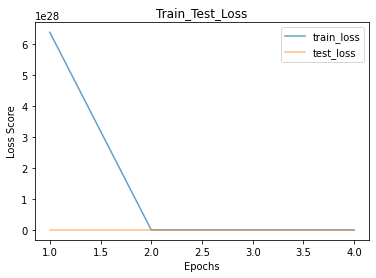

5
Train Epoch: 5 [0/7471 (0%)]	Loss: 1973123022848.000000
Train Epoch: 5 [160/7471 (2%)]	Loss: 1458781421568.000000
Train Epoch: 5 [320/7471 (4%)]	Loss: 946865335959552.000000
Train Epoch: 5 [480/7471 (6%)]	Loss: 1361390731264.000000
Train Epoch: 5 [640/7471 (9%)]	Loss: 518885904220160.000000
Train Epoch: 5 [800/7471 (11%)]	Loss: 1297423925248.000000
Train Epoch: 5 [960/7471 (13%)]	Loss: 904529379328.000000
Train Epoch: 5 [1120/7471 (15%)]	Loss: 1394692849664.000000
Train Epoch: 5 [1280/7471 (17%)]	Loss: 526814917165056.000000
Train Epoch: 5 [1440/7471 (19%)]	Loss: 2653996449792.000000
Train Epoch: 5 [1600/7471 (21%)]	Loss: 754935988224.000000
Train Epoch: 5 [1760/7471 (24%)]	Loss: 1729433305088.000000
Train Epoch: 5 [1920/7471 (26%)]	Loss: 2223578284032.000000
Train Epoch: 5 [2080/7471 (28%)]	Loss: 984109809664.000000
Train Epoch: 5 [2240/7471 (30%)]	Loss: 2144951336960.000000
Train Epoch: 5 [2400/7471 (32%)]	Loss: 2040260984832.000000
Train Epoch: 5 [2560/7471 (34%)]	Loss: 1413247270

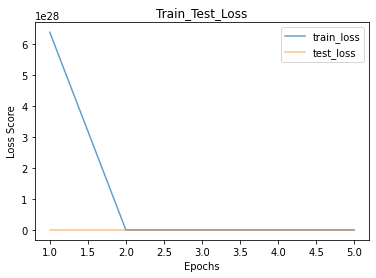

6
Train Epoch: 6 [0/7471 (0%)]	Loss: 489852395061248.000000
Train Epoch: 6 [160/7471 (2%)]	Loss: 1624310939648.000000
Train Epoch: 6 [320/7471 (4%)]	Loss: 2018728476672.000000
Train Epoch: 6 [480/7471 (6%)]	Loss: 1986920185856.000000
Train Epoch: 6 [640/7471 (9%)]	Loss: 1680797073408.000000
Train Epoch: 6 [800/7471 (11%)]	Loss: 484452178329600.000000
Train Epoch: 6 [960/7471 (13%)]	Loss: 1670794313728.000000
Train Epoch: 6 [1120/7471 (15%)]	Loss: 1314983116800.000000
Train Epoch: 6 [1280/7471 (17%)]	Loss: 530616097439744.000000
Train Epoch: 6 [1440/7471 (19%)]	Loss: 2304190971904.000000
Train Epoch: 6 [1600/7471 (21%)]	Loss: 898673923850240.000000
Train Epoch: 6 [1760/7471 (24%)]	Loss: 1281053587144704.000000
Train Epoch: 6 [1920/7471 (26%)]	Loss: 659012265705472.000000
Train Epoch: 6 [2080/7471 (28%)]	Loss: 2339155214336.000000
Train Epoch: 6 [2240/7471 (30%)]	Loss: 1584625876992.000000
Train Epoch: 6 [2400/7471 (32%)]	Loss: 728378179584.000000
Train Epoch: 6 [2560/7471 (34%)]	Loss: 4

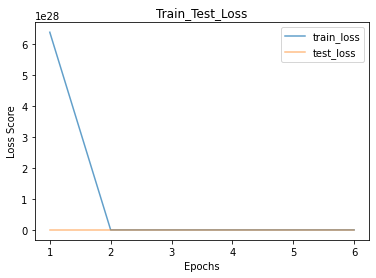

7
Train Epoch: 7 [0/7471 (0%)]	Loss: 1029696389120.000000
Train Epoch: 7 [160/7471 (2%)]	Loss: 1319249379328.000000
Train Epoch: 7 [320/7471 (4%)]	Loss: 1978337067008.000000
Train Epoch: 7 [480/7471 (6%)]	Loss: 1528048123904.000000
Train Epoch: 7 [640/7471 (9%)]	Loss: 1847565484032.000000
Train Epoch: 7 [800/7471 (11%)]	Loss: 1995538300928.000000
Train Epoch: 7 [960/7471 (13%)]	Loss: 1316424384512.000000
Train Epoch: 7 [1120/7471 (15%)]	Loss: 2303136366592.000000
Train Epoch: 7 [1280/7471 (17%)]	Loss: 2303880593408.000000
Train Epoch: 7 [1440/7471 (19%)]	Loss: 2105177276416.000000
Train Epoch: 7 [1600/7471 (21%)]	Loss: 813207497211904.000000
Train Epoch: 7 [1760/7471 (24%)]	Loss: 1740999360512.000000
Train Epoch: 7 [1920/7471 (26%)]	Loss: 1261783482368.000000
Train Epoch: 7 [2080/7471 (28%)]	Loss: 2332405792768.000000
Train Epoch: 7 [2240/7471 (30%)]	Loss: 1422735704064.000000
Train Epoch: 7 [2400/7471 (32%)]	Loss: 948810088448.000000
Train Epoch: 7 [2560/7471 (34%)]	Loss: 696249565052

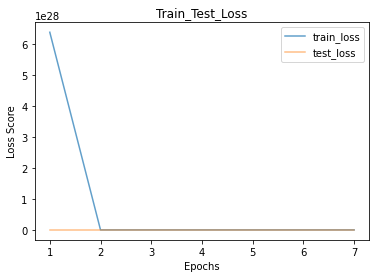

8
Train Epoch: 8 [0/7471 (0%)]	Loss: 2602856873984.000000
Train Epoch: 8 [160/7471 (2%)]	Loss: 1647926837248.000000
Train Epoch: 8 [320/7471 (4%)]	Loss: 1256384364544.000000
Train Epoch: 8 [480/7471 (6%)]	Loss: 1523167002624.000000
Train Epoch: 8 [640/7471 (9%)]	Loss: 2076762439680.000000
Train Epoch: 8 [800/7471 (11%)]	Loss: 2130522931200.000000
Train Epoch: 8 [960/7471 (13%)]	Loss: 465396213743616.000000
Train Epoch: 8 [1120/7471 (15%)]	Loss: 382987703156736.000000
Train Epoch: 8 [1280/7471 (17%)]	Loss: 1668746969088.000000
Train Epoch: 8 [1440/7471 (19%)]	Loss: 3368897478656.000000
Train Epoch: 8 [1600/7471 (21%)]	Loss: 1657045516288.000000
Train Epoch: 8 [1760/7471 (24%)]	Loss: 1090637135872.000000
Train Epoch: 8 [1920/7471 (26%)]	Loss: 2228489027584.000000
Train Epoch: 8 [2080/7471 (28%)]	Loss: 2551257235456.000000
Train Epoch: 8 [2240/7471 (30%)]	Loss: 994074099712.000000
Train Epoch: 8 [2400/7471 (32%)]	Loss: 2352585375744.000000
Train Epoch: 8 [2560/7471 (34%)]	Loss: 1547226972

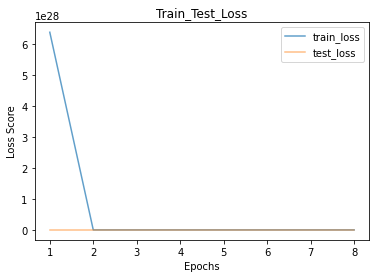

9
Train Epoch: 9 [0/7471 (0%)]	Loss: 336971054448640.000000
Train Epoch: 9 [160/7471 (2%)]	Loss: 368447393366016.000000
Train Epoch: 9 [320/7471 (4%)]	Loss: 2030656815104.000000
Train Epoch: 9 [480/7471 (6%)]	Loss: 1595073363968.000000
Train Epoch: 9 [640/7471 (9%)]	Loss: 1858610659328.000000
Train Epoch: 9 [800/7471 (11%)]	Loss: 1351744356352.000000
Train Epoch: 9 [960/7471 (13%)]	Loss: 3010950856704.000000
Train Epoch: 9 [1120/7471 (15%)]	Loss: 1273283608576.000000
Train Epoch: 9 [1280/7471 (17%)]	Loss: 956257337344.000000
Train Epoch: 9 [1440/7471 (19%)]	Loss: 22272252993077248.000000
Train Epoch: 9 [1600/7471 (21%)]	Loss: 79738902528655360.000000
Train Epoch: 9 [1760/7471 (24%)]	Loss: 73325554283053056.000000
Train Epoch: 9 [1920/7471 (26%)]	Loss: 2013614047232.000000
Train Epoch: 9 [2080/7471 (28%)]	Loss: 10550795468537856.000000
Train Epoch: 9 [2240/7471 (30%)]	Loss: 912837246976.000000
Train Epoch: 9 [2400/7471 (32%)]	Loss: 6447248422469632.000000
Train Epoch: 9 [2560/7471 (34%)

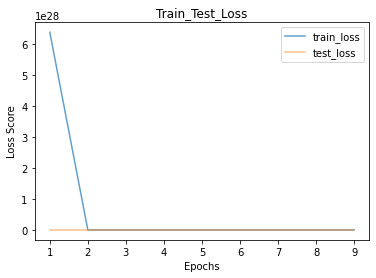

10
Train Epoch: 10 [0/7471 (0%)]	Loss: 1110615261184.000000
Train Epoch: 10 [160/7471 (2%)]	Loss: 2576704864256.000000
Train Epoch: 10 [320/7471 (4%)]	Loss: 1411862233088.000000
Train Epoch: 10 [480/7471 (6%)]	Loss: 1942731014275072.000000
Train Epoch: 10 [640/7471 (9%)]	Loss: 1082533085184.000000
Train Epoch: 10 [800/7471 (11%)]	Loss: 1994723472441344.000000
Train Epoch: 10 [960/7471 (13%)]	Loss: 1536293470208.000000
Train Epoch: 10 [1120/7471 (15%)]	Loss: 1309483728896.000000
Train Epoch: 10 [1280/7471 (17%)]	Loss: 1230046625792.000000
Train Epoch: 10 [1440/7471 (19%)]	Loss: 841449472000.000000
Train Epoch: 10 [1600/7471 (21%)]	Loss: 1365195358208.000000
Train Epoch: 10 [1760/7471 (24%)]	Loss: 1102971011072.000000
Train Epoch: 10 [1920/7471 (26%)]	Loss: 1047775412224.000000
Train Epoch: 10 [2080/7471 (28%)]	Loss: 2428850667520.000000
Train Epoch: 10 [2240/7471 (30%)]	Loss: 1386382491648.000000
Train Epoch: 10 [2400/7471 (32%)]	Loss: 1303836912254976.000000
Train Epoch: 10 [2560/7471 

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


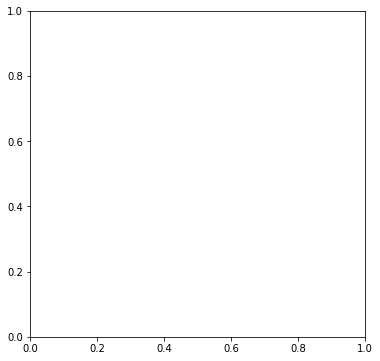

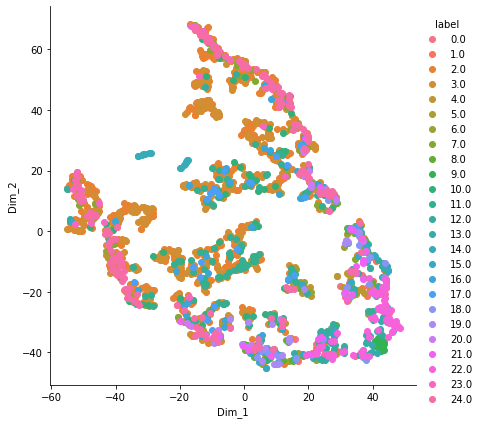

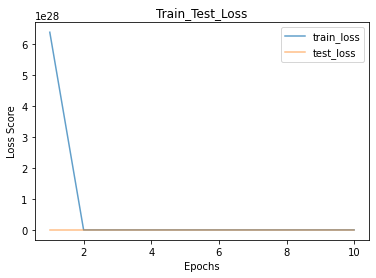

11
Train Epoch: 11 [0/7471 (0%)]	Loss: 1276109542916096.000000
Train Epoch: 11 [160/7471 (2%)]	Loss: 1928125480960.000000
Train Epoch: 11 [320/7471 (4%)]	Loss: 1143713038336.000000
Train Epoch: 11 [480/7471 (6%)]	Loss: 1403834466304.000000
Train Epoch: 11 [640/7471 (9%)]	Loss: 2000483385344.000000
Train Epoch: 11 [800/7471 (11%)]	Loss: 1255028686848.000000
Train Epoch: 11 [960/7471 (13%)]	Loss: 1336789565440.000000
Train Epoch: 11 [1120/7471 (15%)]	Loss: 1710607302656.000000
Train Epoch: 11 [1280/7471 (17%)]	Loss: 1221830508544.000000
Train Epoch: 11 [1440/7471 (19%)]	Loss: 1271873011712.000000
Train Epoch: 11 [1600/7471 (21%)]	Loss: 1755671166976.000000
Train Epoch: 11 [1760/7471 (24%)]	Loss: 2066687066112.000000
Train Epoch: 11 [1920/7471 (26%)]	Loss: 1405379149824.000000
Train Epoch: 11 [2080/7471 (28%)]	Loss: 1561556156416.000000
Train Epoch: 11 [2240/7471 (30%)]	Loss: 1146998882304.000000
Train Epoch: 11 [2400/7471 (32%)]	Loss: 773691583496192.000000
Train Epoch: 11 [2560/7471 (34

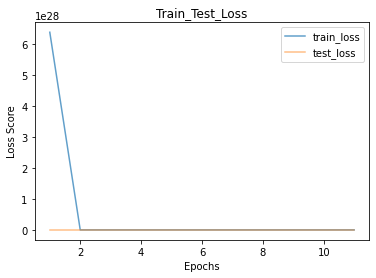

12
Train Epoch: 12 [0/7471 (0%)]	Loss: 713928212480.000000
Train Epoch: 12 [160/7471 (2%)]	Loss: 1863877525504.000000
Train Epoch: 12 [320/7471 (4%)]	Loss: 739061799059456.000000
Train Epoch: 12 [480/7471 (6%)]	Loss: 1636019994624.000000
Train Epoch: 12 [640/7471 (9%)]	Loss: 1173538340864.000000
Train Epoch: 12 [800/7471 (11%)]	Loss: 1315271591591936.000000
Train Epoch: 12 [960/7471 (13%)]	Loss: 1326630699008.000000
Train Epoch: 12 [1120/7471 (15%)]	Loss: 1051712749568.000000
Train Epoch: 12 [1280/7471 (17%)]	Loss: 1915174780928.000000
Train Epoch: 12 [1440/7471 (19%)]	Loss: 1157561843712.000000
Train Epoch: 12 [1600/7471 (21%)]	Loss: 409293505429504.000000
Train Epoch: 12 [1760/7471 (24%)]	Loss: 1006196228096.000000
Train Epoch: 12 [1920/7471 (26%)]	Loss: 847755542528.000000
Train Epoch: 12 [2080/7471 (28%)]	Loss: 1185595392000.000000
Train Epoch: 12 [2240/7471 (30%)]	Loss: 1154816147456.000000
Train Epoch: 12 [2400/7471 (32%)]	Loss: 1273456099328.000000
Train Epoch: 12 [2560/7471 (34

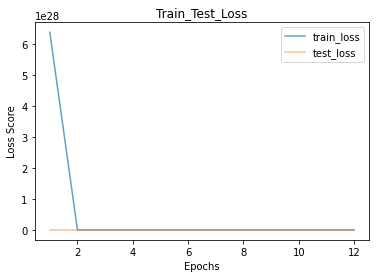

13
Train Epoch: 13 [0/7471 (0%)]	Loss: 1656679694336.000000
Train Epoch: 13 [160/7471 (2%)]	Loss: 2308067033088.000000
Train Epoch: 13 [320/7471 (4%)]	Loss: 1364977647616.000000
Train Epoch: 13 [480/7471 (6%)]	Loss: 3456844955648.000000
Train Epoch: 13 [640/7471 (9%)]	Loss: 1597897834496.000000
Train Epoch: 13 [800/7471 (11%)]	Loss: 1691705933824.000000
Train Epoch: 13 [960/7471 (13%)]	Loss: 1106763055104.000000
Train Epoch: 13 [1120/7471 (15%)]	Loss: 2098524454912.000000
Train Epoch: 13 [1280/7471 (17%)]	Loss: 2113806532608.000000
Train Epoch: 13 [1440/7471 (19%)]	Loss: 1811579011072.000000
Train Epoch: 13 [1600/7471 (21%)]	Loss: 1873433985024.000000
Train Epoch: 13 [1760/7471 (24%)]	Loss: 473923636428800.000000
Train Epoch: 13 [1920/7471 (26%)]	Loss: 265432619548672.000000
Train Epoch: 13 [2080/7471 (28%)]	Loss: 1618628575232.000000
Train Epoch: 13 [2240/7471 (30%)]	Loss: 1614459305984.000000
Train Epoch: 13 [2400/7471 (32%)]	Loss: 1333420228608.000000
Train Epoch: 13 [2560/7471 (34%

RuntimeError: ignored

In [22]:
epochs = 20

for epoch in range(1, epochs + 1):
        print(epoch)
        train(epoch)
        test(epoch)
        # https://stackoverflow.com/questions/40766909/suggestions-to-plot-overlapping-lines-in-matplotlib
        plt.plot(Epoch_Loss['train_epoch'],Epoch_Loss['train_loss'], label="train_loss", alpha=0.7)
        plt.plot(Epoch_Loss['test_epoch'],Epoch_Loss['test_loss'], label="test_loss", alpha=0.5)
        plt.xlabel('Epochs')
        plt.ylabel('Loss Score')
        plt.title('Train_Test_Loss')
        plt.legend()
        plt.savefig('./Exp05_results/plot_train_test_loss/'+str(epoch)+'_epoch.png', dpi=300)
        plt.show()

        with torch.no_grad():
            sample = torch.randn(64, 100).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 224, 224),
                       './Exp05_results/recon_sampling/sampling_' + str(epoch) + '.png')

### Training 일지


1. 생각보다 한 Epoch도는데 시간이 오래걸린다...하하

* Training이 중간에 꺼지는 것을 방지하기위해... 15분 단위로 text를 하나씩 작성해야 하나...
* 좋은 결과가 있었으면 좋겠다... 우주의 기운아...!!
* 1Epoch 이후로는 속사포다!
* 돌고돈다 조금 긴장되는 순간 조큼!
* Epoch 1에서 계속해서 작업이 진행중이다.
    * pros: training 하느라 고생이 많군!
    * cons: 흠... 긴장된다... error 아냐??
* Error가 발생하더라도 다시 간다!
* 아직까지도 1 Epoch이 돌지 않았다는건 뭔가 잘못됬다는 증거...?!

오... 1 Epoch을 도는데 30분정도 걸린거 같은데 다행히 Error는 없었다!
* 5Epoch까지 순항중

--- 
가즈아

10 Epoch만 무사히 넘기면 계속 학습 가능

* 과연 10 Epoch 후 환상의 manifold를 볼 수 있을 것인가

---
2. 환상의 manifold를 뽑아줬다!! 그런데....!reconstruction 결과를 보면 영 아니지 않는가...?!

200 Epoch까지 갔을 때의 결과가 너무 궁금하다<br><br>

*1Epoch당 1분정도의 시간이 소요되는 것 같다*
<br>
* 20 Epoch: 
    * reconstruction 결과가 좋지 않다. 
    * 우선 학습이 진행됨에 따라 경과를 지켜보자 
* 30 Epoch
* 40 Epoch

---
3. linear layer만으로는 학습을 시키는데 한계가 있지 않을까?
* 이번 학습을 마지막으로 200Epoch까지 결과를 보고 추후 연구에 대한 방향을 재설정할 필요가 있다고 생각한다.

1. Linear Layer를 변경한다.
2. CNN Layer를 사용하면 조금 달라질까?

다행인것은 test_loss가 train loss보다 계속해서 작다는 것이다. 정말 다행인지는 잘 모르겠지만!



---
중간중간 결과 해석을 어떻게 해야할지 모르겠다...
그리고 이 실험이 지금 어디로 가는지도...하하

<br>
최종 결과는 학습이 끝난 뒤에 판단하는걸로 하자.<br>
결과가 좋든 나쁘든 간에 Epoch 단위로 결과를 보는 것도 상당히 흥미롭다.